# Cell type classification

2021-04-15

In [1]:
# Import Packages

%load_ext autoreload
%autoreload 2

import os
import warnings 
warnings.filterwarnings('ignore')
import numpy as np
import pandas as pd
import scanpy as sc
import seaborn as sns
import matplotlib.pyplot as plt
from skimage.filters import threshold_otsu, gaussian
from skimage.morphology import remove_small_objects
from matplotlib.colors import ListedColormap
from anndata import AnnData

# Customized packages
from starmap.utilities import *
from starmap.sequencing import *
from starmap.obj import STARMapDataset, load_data
import starmap.analyze as anz
import starmap.viz as viz
import starmap.sc_util as su


# test()

In [2]:
# Get functions 

import colorsys
from random import shuffle

def intervals(parts, start_point, end_point):
    duration = end_point - start_point
    part_duration = duration / parts
    return [((i * part_duration + (i + 1) * part_duration)/2) + start_point for i in range(parts)]

## Input

In [3]:
# Set path
base_path = './'
out_path = os.path.join(base_path, 'output')
fig_path = os.path.join(base_path, 'figures')
if not os.path.exists(fig_path):
    os.mkdir(fig_path)

expr_path = os.path.join(out_path, 'complete_cell_barcode_count.csv')
var_path = os.path.join(out_path, 'cell_barcode_names.csv')
obs_path = os.path.join(out_path, 'complete_meta.csv')

# Add expression data to the AnnData object 
expr_x = np.loadtxt(expr_path, delimiter=',')
var = pd.read_csv(var_path, header=None)
var = pd.DataFrame(index=var.iloc[:,2].to_list())
obs = pd.read_csv(obs_path, index_col=0)

adata = AnnData(X=expr_x, var=var, obs=obs)

In [4]:
# Add additional metadata

# add batch information 
adata.obs.loc[adata.obs['sample'] == 'AD_mouse9723', 'batch'] = 'batch_1'
adata.obs.loc[adata.obs['sample'] == 'AD_mouse9735', 'batch'] = 'batch_1'
adata.obs.loc[adata.obs['sample'] == 'AD_mouse9494', 'batch'] = 'batch_2'
adata.obs.loc[adata.obs['sample'] == 'AD_mouse9498', 'batch'] = 'batch_2'

# add time information 
adata.obs.loc[adata.obs['sample'] == 'AD_mouse9723', 'time'] = '8_months'
adata.obs.loc[adata.obs['sample'] == 'AD_mouse9735', 'time'] = '8_months'
adata.obs.loc[adata.obs['sample'] == 'AD_mouse9494', 'time'] = '13_months'
adata.obs.loc[adata.obs['sample'] == 'AD_mouse9498', 'time'] = '13_months'

# add group information 
adata.obs.loc[adata.obs['sample'] == 'AD_mouse9723', 'group'] = 'disease'
adata.obs.loc[adata.obs['sample'] == 'AD_mouse9735', 'group'] = 'control'
adata.obs.loc[adata.obs['sample'] == 'AD_mouse9494', 'group'] = 'disease'
adata.obs.loc[adata.obs['sample'] == 'AD_mouse9498', 'group'] = 'control'

# change dtype
adata.obs['sample'] = adata.obs['sample'].astype('category')
adata.obs['sample'] = adata.obs['sample'].cat.reorder_categories(['AD_mouse9735', 'AD_mouse9723', 'AD_mouse9498', 'AD_mouse9494'])

adata.obs['batch'] = adata.obs['batch'].astype('category')
adata.obs['batch'] = adata.obs['batch'].cat.reorder_categories(['batch_1', 'batch_2'])

adata.obs['time'] = adata.obs['time'].astype('category')
adata.obs['time'] = adata.obs['time'].cat.reorder_categories(['8_months', '13_months'])

adata.obs['group'] = adata.obs['group'].astype('category')

In [5]:
# Preview adata
adata

AnnData object with n_obs × n_vars = 37067 × 2766
    obs: 'orig_index', 'sample', 'area', 'tau', 'x', 'y', 'batch', 'time', 'group'

In [6]:
adata.obs['group'].value_counts()

disease    19932
control    17135
Name: group, dtype: int64

In [7]:
adata.obs['sample'].value_counts()

AD_mouse9494    10743
AD_mouse9723     9189
AD_mouse9735     8896
AD_mouse9498     8239
Name: sample, dtype: int64

## Preprocessing

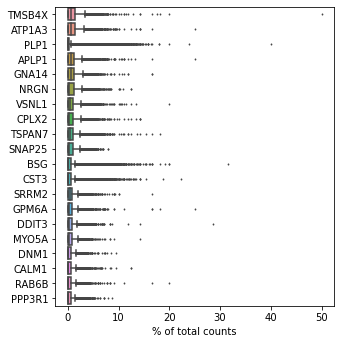

In [8]:
# Plot top 20 most expressed genes 
sc.pl.highest_expr_genes(adata, n_top=20)

In [9]:
# Calculate QC metrics
sc.pp.calculate_qc_metrics(adata, percent_top=None, inplace=True)
# Calculate max count for each gene
adata.var['max_counts'] = adata.X.max(axis=0)

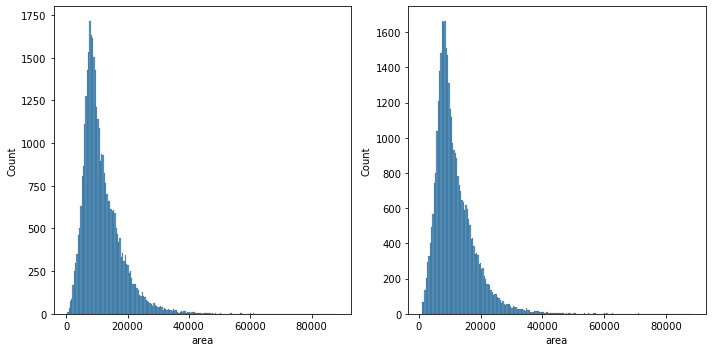

Number of cell left: 37041


In [10]:
# Filter cell by area 
adata = su.filter_cells_by_area(adata, min_area=1000, max_area=100000, save=False)

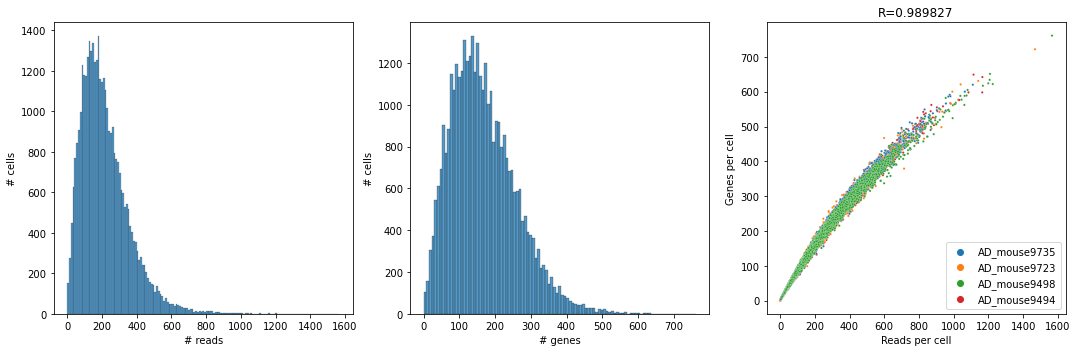

In [11]:
# Per-cell Stats Plot
su.plot_stats_per_cell(adata, save=False)

In [12]:
# Get quantiles of reads
su.show_reads_quantile(adata)

Reads per cell quantile:
0.10     68.0
0.25    118.0
0.50    191.0
0.75    289.0
0.90    398.0
Name: total_counts, dtype: float64


In [13]:
# Get a copy of meta data
meta = adata.obs.copy()

# Filtration 
sc.pp.filter_cells(adata, min_genes=10)
sc.pp.filter_genes(adata, min_cells=10)

# Filter gene by max counts 
adata = adata[:, adata.var['max_counts'] > 2]
# adata.var['detected'] = adata.var['max_counts'] > 2
# adata.var['highly_variable'] = adata.var['max_counts'] > 2

sc.pp.filter_cells(adata, min_counts=68)
sc.pp.filter_cells(adata, max_counts=1500)

adata.layers['raw'] = adata.X
adata.X.shape

Trying to set attribute `.obs` of view, copying.


(33391, 2766)

In [14]:
# Normalization scaling
sc.pp.normalize_total(adata)
sc.pp.log1p(adata)

adata.layers['norm'] = adata.X
adata.raw = adata

In [15]:
# Scale data to unit variance and zero mean
sc.pp.scale(adata)
adata.layers['scaled'] = adata.X

# Batch correction
sc.pp.combat(adata)
adata.layers['corrected'] = adata.X

In [16]:
adata

AnnData object with n_obs × n_vars = 33391 × 2766
    obs: 'orig_index', 'sample', 'area', 'tau', 'x', 'y', 'batch', 'time', 'group', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'n_genes', 'n_counts'
    var: 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'max_counts', 'n_cells', 'highly_variable', 'mean', 'std'
    uns: 'log1p'
    layers: 'raw', 'norm', 'scaled', 'corrected'

## Top-level clustering

In [ ]:
# Run PCA
sc.tl.pca(adata, svd_solver='arpack', use_highly_variable=True)

# Plot explained variance 
sc.pl.pca_variance_ratio(adata, log=False)

In [ ]:
# Plot PCA
sc.pl.pca(adata, color='batch')
sc.pl.pca(adata, color='sample')
sc.pl.pca(adata, color='group')

In [ ]:
%%time
# Computing the neighborhood graph
n_neighbors = 50
n_pcs = 30
    
sc.pp.neighbors(adata, n_neighbors=n_neighbors, n_pcs=n_pcs)

# Run UMAP
sc.tl.umap(adata)

In [ ]:
%%time
# Run leiden cluster
cluster_resolution = 1
sc.tl.leiden(adata, resolution = cluster_resolution)

# Plot UMAP with cluster labels 
sc.pl.umap(adata, color='leiden')
n_clusters = adata.obs['leiden'].unique().shape[0]

# Save log
with open(f'./figures/log.txt', 'w') as f:
    f.write(f"""Number of neighbor: {n_neighbors}
Number of PC: {n_pcs}
Resolution: {cluster_resolution}
Number of clusters: {n_clusters}""")

In [ ]:
# Get colormap
cluster_pl = sns.color_palette("Set3", n_clusters)
cluster_cmap = ListedColormap(cluster_pl.as_hex())
sns.palplot(cluster_pl)

In [ ]:
# Plot UMAP with cluster labels w/ new color
sc.pl.umap(adata, color='leiden', legend_loc='on data',
           legend_fontsize=12, legend_fontoutline=2, frameon=False, 
           title='Top level clustering (leiden)', palette=cluster_pl, save=False)

In [ ]:
# Get markers for each cluster
sc.tl.rank_genes_groups(adata, 'leiden', method='wilcoxon')

# Plot z-score heatmap
sc.pl.rank_genes_groups_heatmap(adata, n_genes=10, min_logfoldchange=1, use_raw=False, swap_axes=True, 
                                vmin=-5, vmax=5, cmap='bwr', show_gene_labels=True,
                                dendrogram=False, figsize=(30, 15), save=False)

In [ ]:
# Print markers 
markers = []
temp = pd.DataFrame(adata.uns['rank_genes_groups']['names']).head(5)
for i in range(temp.shape[1]):
    curr_col = temp.iloc[:, i].to_list()
    markers = markers + curr_col
    print(i, curr_col)


## Morphology

In [ ]:
# Load data and store the information to uns (use scaled version to save computational time)
for sample in sorted(adata.obs['sample'].unique()):
    print(sample)
    
    # Load segmentation
    current_seg_path = os.path.join(sample, 'scaled/labeled_cells.tif')
    current_img = tifffile.imread(current_seg_path)
    
    # Load plaque image
    current_plaque_path = os.path.join(sample, 'scaled/plaque.tif')
    current_plaque = tifffile.imread(current_plaque_path)
    # uniform manual threshold 
    current_plaque = gaussian(current_plaque.astype(np.float), 2) > 30
    # current_plaque = remove_small_objects(current_plaque, min_size=64, connectivity=4)
    
    # Load tau image
    current_tau_path = os.path.join(sample, 'scaled/tau_mask.tif')
    current_tau = tifffile.imread(current_tau_path)

    # Store the images to adata object
    current_key = f"{sample}_morph"
    adata.uns[current_key] = {}
    adata.uns[current_key]['label_img'] = current_img
    adata.uns[current_key]['plaque'] = current_plaque
    adata.uns[current_key]['tau'] = current_tau

In [ ]:
# Extract spatial information and store the information to uns
for sample in sorted(adata.obs['sample'].unique()):
    print(sample)
    
    current_key = f"{sample}_morph"
    adata.uns[current_key]['qhulls'], adata.uns[current_key]['coords'], adata.uns[current_key]['centroids'] = su.get_qhulls(current_img)

In [ ]:
# Add tau information 
for sample in sorted(adata.obs['sample'].unique()):
    print(sample)
    
    current_key = f"{sample}_morph"
    labels = adata.uns[current_key]['label_img']
    tau = adata.uns[current_key]['tau'] > 1
    current_index = adata.obs.loc[adata.obs['sample'] == sample, 'orig_index'].values
    tau_intensity = []
    for i, region in enumerate(regionprops(labels)):
        # print(region.label)
        if i in current_index:
            # tau intensity
            curr_intensity = np.sum(tau[region.coords[:, 0], region.coords[:, 1]])
            curr_intensity = curr_intensity / region.area * 100
            tau_intensity.append(round(curr_intensity, 2))
    adata.obs.loc[adata.obs['sample'] == sample, 'tau'] = tau_intensity

### Top-level leiden spatial map

In [ ]:
# Get good cells and colors to plot the spatial map 
for sample in sorted(adata.obs['sample'].unique()):
    print(sample)
    
    current_key = f"{sample}_morph"
    current_index = adata.obs['sample'] == sample
    adata.uns[current_key]['good_cells'] = adata.obs.loc[current_index, 'orig_index'].astype(int).values
    adata.uns[current_key]['colors'] = adata.obs.loc[current_index, 'leiden'].astype(int).values

In [ ]:
# Plot the spatial map for each sample 
for sample in sorted(adata.obs['sample'].unique()):
    print(sample)
    
    su.plot_poly_cells_cluster_by_sample(adata, sample, cluster_cmap, show_plaque=True, show_tau=True,
                                        figscale=30, width=10, height=10, save=True, show=False)

## Top-level cluster annotation

In [ ]:
# Plot UMAP with cluster labels w/ new color
sc.pl.umap(adata, color='leiden', legend_loc='on data',
           legend_fontsize=12, legend_fontoutline=2, frameon=False, 
           title='Top level clustering (leiden)', palette=cluster_pl, save=False)

In [ ]:
# Print markers 
markers = []
temp = pd.DataFrame(adata.uns['rank_genes_groups']['names']).head(5)
for i in range(temp.shape[1]):
    curr_col = temp.iloc[:, i].to_list()
    markers = markers + curr_col
    print(i, curr_col)


In [ ]:
# Change cluster label to cell type label
transfer_dict = {}
top_level_list = ['Ex', 'Oligo', 'DG', 'Astro', 'CA1', 'CA3', 'Inhi', 'Endo', 'Micro', 'SMC', 'OPC', 'LHb']

for i in sorted(adata.obs['leiden'].unique()):
    transfer_dict[i] = top_level_list[int(i)]

In [ ]:
# Assign cell type to sdata
adata.obs['top_level'] = adata.obs['leiden'].values
adata.obs = adata.obs.replace({'top_level': transfer_dict})

# Sort category
top_level_order = ['Ex', 'Inhi', 'CA1', 'CA3', 'DG', 'Astro', 'Endo', 'Micro', 'Oligo', 'OPC', 'SMC', 'LHb']
adata.obs['top_level'] = adata.obs['top_level'].astype('category')
adata.obs['top_level'].cat.reorder_categories(top_level_order, inplace=True)

In [ ]:
# Check color legend
sns.palplot(cluster_pl, size=3)
plt.xticks(range(len(top_level_order)), top_level_order, size=10, rotation=45)
plt.tight_layout()
plt.savefig(f'./figures/color_legend_top.png')
plt.show()

In [ ]:
# Save plots
# Plot UMAP with cluster labels w/ new color
sc.pl.umap(adata, color='top_level', legend_loc='on data',
           legend_fontsize=12, legend_fontoutline=2, frameon=False, 
           title='Top level clustering (leiden)', palette=cluster_pl, save=True)

sc.tl.rank_genes_groups(adata, 'top_level', method='wilcoxon')

# Plot logFC heatmap
sc.pl.rank_genes_groups_heatmap(adata, n_genes=5, groupby='top_level', min_logfoldchange=1, use_raw=False, swap_axes=True, 
                                vmin=-5, vmax=5, cmap='bwr', show_gene_labels=True, values_to_plot='logfoldchanges',
                                dendrogram=False, figsize=(30, 15), save='_logFC')

# Plot z-score heatmap
sc.pl.rank_genes_groups_heatmap(adata, n_genes=5, groupby='top_level', min_logfoldchange=1, use_raw=False, swap_axes=True, 
                                vmin=-5, vmax=5, cmap='bwr', show_gene_labels=True,
                                dendrogram=False, figsize=(30, 15), save='_zscore')

# Plot logFC dotplot
sc.pl.rank_genes_groups_dotplot(adata, groupby='top_level', n_genes=5, values_to_plot='logfoldchanges', min_logfoldchange=1, 
                                vmax=5, vmin=-5, cmap='bwr', save='logFC')

# Print markers 
markers = []
temp = pd.DataFrame(adata.uns['rank_genes_groups']['names']).head(5)
for i in range(temp.shape[1]):
    curr_col = temp.iloc[:, i].to_list()
    markers = markers + curr_col
    print(curr_col)


### Top-level spatial map

In [ ]:
# Get good cells and colors to plot the spatial map 
for sample in sorted(adata.obs['sample'].unique()):
    print(sample)
    
    current_key = f"{sample}_morph"
    current_index = adata.obs['sample'] == sample
    adata.uns[current_key]['good_cells'] = adata.obs.loc[current_index, 'orig_index'].astype(int).values
    adata.uns[current_key]['colors'] = adata.obs.loc[current_index, 'top_level'].cat.codes.values

In [ ]:
# Plot the spatial map for each sample 
for sample in sorted(adata.obs['sample'].unique()):
    print(sample)
    
    su.plot_poly_cells_cluster_by_sample(adata, sample, cluster_cmap, show_plaque=True, show_tau=True,
                                        figscale=30, width=10, height=10, save=True, show=False)

## Sub-level clustering

In [ ]:
# Create complete array
complete_cluster_pl = []
complete_cell_type_order = []

<hr>

In [ ]:
# Subset
sub_id = 'OPC'
curr_cells = adata.obs['top_level'] == sub_id
sdata = adata[curr_cells, :]
sdata

In [ ]:
# Run PCA
sc.tl.pca(sdata, svd_solver='arpack', use_highly_variable=True)

# Plot explained variance 
sc.pl.pca_variance_ratio(sdata, log=False)

# Plot PCA
sc.pl.pca(sdata, color='sample')

In [ ]:
%%time
# Computing the neighborhood graph
n_neighbors = 30
n_pcs = 10

sc.pp.neighbors(sdata, n_neighbors=n_neighbors, n_pcs=n_pcs)

# Run UMAP
sc.tl.umap(sdata)

In [ ]:
# Plot UMAP
sc.pl.umap(sdata, color='sample', save=f'_{sub_id}_sample')
sc.pl.umap(sdata, color='time', save=f'_{sub_id}_time')
sc.pl.umap(sdata, color='group', save=f'_{sub_id}_group')

In [ ]:
%%time
# Run leiden cluster
cluster_resolution = .2
sc.tl.leiden(sdata, resolution = cluster_resolution)

# Plot UMAP with cluster labels 
sc.pl.umap(sdata, color='leiden')
n_clusters = sdata.obs['leiden'].unique().shape[0]

# Save log
with open(f'./figures/log_{sub_id}.txt', 'w') as f:
    f.write(f"""Number of neighbor: {n_neighbors}
Number of PC: {n_pcs}
Resolution: {cluster_resolution}
Number of clusters: {n_clusters}""")

In [ ]:
# Get colormap 
cluster_pl = sns.color_palette('Set2', n_clusters)
sns.palplot(cluster_pl)
cluster_cmap = ListedColormap(cluster_pl)

In [ ]:
# Plot UMAP with cluster labels w/ new color
sc.pl.umap(sdata, color='leiden', legend_loc='on data',
           legend_fontsize=12, legend_fontoutline=2, frameon=False, 
           title=f'leiden clustering (resolution={cluster_resolution})', palette=cluster_pl)

In [ ]:
# Get markers for each cluster
sc.tl.rank_genes_groups(sdata, 'leiden', method='wilcoxon')

# Plot z-score heatmap
sc.pl.rank_genes_groups_heatmap(sdata, n_genes=5, min_logfoldchange=.5, use_raw=False, swap_axes=True, 
                                vmin=-5, vmax=5, cmap='bwr', show_gene_labels=True,
                                dendrogram=False, figsize=(30, 15), save=False)

In [ ]:
# Print markers 
markers = []
temp = pd.DataFrame(sdata.uns['rank_genes_groups']['names']).head(5)
for i in range(temp.shape[1]):
    curr_col = temp.iloc[:, i].to_list()
    markers = markers + curr_col
    print(i, curr_col)

### Sub-level leiden spatial map

In [ ]:
# Check cluster spatial pattern 
for sample in sorted(sdata.obs['sample'].unique()):
    print(sample)
    current_key = f"{sample}_morph"

    current_index = sdata.obs['sample'] == sample
    sdata.uns[current_key]['good_cells'] = sdata.obs.loc[current_index, 'orig_index'].astype(int).values
    sdata.uns[current_key]['colors'] = sdata.obs.loc[current_index, 'leiden'].astype(int).values

In [ ]:
# Check current spatial cell type 
n_plots = 1
for i, sample in enumerate(sorted(sdata.obs['sample'].unique())[:n_plots]):
    print(sample)
    su.plot_poly_cells_cluster_by_sample(sdata, sample, cluster_cmap, show_plaque=True, show_tau=True,
                                        figscale=5, width=10, height=10)

## Sub-level Cluster Annotation

In [ ]:
# Change cluster label to cell type label
transfer_dict = {}
# cell_type_list = ['CA3', 'CA2']
# cell_type_list = ['Inhi_Pvalb', 'Inhi_Sst', 'Inhi_Cnr1', 'Inhi_Lamp5']
# cell_type_list = ['L4/RSC_A', 'L6', 'L2/3', 'L4/RSC_B']
# cell_type_list = ['Endo', 'Endo_Cldn5+', 'Endo_Esam+']
# cell_type_list = ['Astro', 'Astro_Aqp4/Gfap', 'Astro_Gpr37l1/Cst3', 'Astro_Id4/Cst3']
# cell_type_list = ['Micro', 'Micro_Cst7/Ctsb', 'Micro_Gpr34']
# cell_type_list = ['Oligo', 'Oligo_Neat1/Enpp2', 'Oligo_Cldn11', 'Oligo_Ntsr1', 'Oligo_Tmem88b',
#                  'Oligo_Klk6', 'Oligo_Itga9']
# cell_type_list = ['Peri_A', 'Peri_B', 'SMC', 'VLMC_A', 'VLMC_B']
cell_type_list = ['OPC', 'OPC_Gpr17']

for i in sorted(sdata.obs['leiden'].unique()):
    transfer_dict[i] = cell_type_list[int(i)]

In [ ]:
# Assign cell type to sdata
sdata.obs['cell_type'] = sdata.obs['leiden'].values
sdata.obs = sdata.obs.replace({'cell_type': transfer_dict})

# Sort category
cell_type_list = sorted(cell_type_list)
sdata.obs['cell_type'] = sdata.obs['cell_type'].astype('category')
sdata.obs['cell_type'].cat.reorder_categories(cell_type_list, inplace=True)

In [ ]:
# Check color legend
sns.palplot(cluster_pl, size=3)
plt.xticks(range(len(cell_type_list)), cell_type_list, size=10, rotation=45)
plt.tight_layout()
plt.savefig(f'./figures/color_legend_{sub_id}.png')
plt.show()

In [ ]:
# Save plots
# Plot UMAP with cluster labels w/ new color
sc.pl.umap(sdata, color='cell_type', legend_loc='on data',
           legend_fontsize=12, legend_fontoutline=2, frameon=False, 
           title=f'leiden clustering (resolution={cluster_resolution})', palette=cluster_pl, save=True)

sc.tl.rank_genes_groups(sdata, 'cell_type', method='wilcoxon')
# Plot logFC heatmap
sc.pl.rank_genes_groups_heatmap(sdata, n_genes=5, groupby='cell_type', min_logfoldchange=.5, use_raw=False, swap_axes=True, 
                                vmin=-5, vmax=5, cmap='bwr', show_gene_labels=True, values_to_plot='logfoldchanges',
                                dendrogram=False, figsize=(30, 15), save='_logFC')

# Plot z-score heatmap
sc.pl.rank_genes_groups_heatmap(sdata, n_genes=5, groupby='cell_type', min_logfoldchange=.5, use_raw=False, swap_axes=True, 
                                vmin=-5, vmax=5, cmap='bwr', show_gene_labels=True,
                                dendrogram=False, figsize=(30, 15), save='_zscore')

# Plot logFC dotplot
sc.pl.rank_genes_groups_dotplot(sdata, groupby='cell_type', n_genes=5, values_to_plot='logfoldchanges', min_logfoldchange=.5, 
                                vmax=5, vmin=-5, cmap='bwr', save='logFC')

# Print markers 
markers = []
temp = pd.DataFrame(sdata.uns['rank_genes_groups']['names']).head(5)
for i in range(temp.shape[1]):
    curr_col = temp.iloc[:, i].to_list()
    markers = markers + curr_col
    print(i, curr_col)

### Sub-level spatial map

In [ ]:
# Check current spatial cell type 
for sample in sorted(sdata.obs['sample'].unique()):
    print(sample)
    current_key = f"{sample}_morph"
    current_index = sdata.obs['sample'] == sample
    
    # change to new color 
    sdata.uns[current_key]['colors'] = sdata.obs.loc[current_index, 'cell_type'].cat.codes.values
    
    su.plot_poly_cells_cluster_by_sample(sdata, sample, cluster_cmap, show_plaque=True, show_tau=True,
                                        figscale=30, width=10, height=10, save=sub_id, show=False)

### Add to adata

In [ ]:
# Map to original obj
if not adata.obs['cell_type']:
    adata.obs['cell_type'] = adata.obs['top_level'].astype(object)
adata.obs['cell_type'] = adata.obs['cell_type'].astype(object)
adata.obs.loc[sdata.obs.index, 'cell_type'] = sdata.obs['cell_type'].values
adata.obs['cell_type'].unique()

In [ ]:
# Update color and cell type order 
complete_cluster_pl = complete_cluster_pl + cluster_pl
complete_cell_type_order = complete_cell_type_order + cell_type_list

In [ ]:
# Check complete meta
sns.palplot(complete_cluster_pl, size=3)
plt.xticks(range(len(complete_cell_type_order)), complete_cell_type_order, size=10, rotation=45)
plt.tight_layout()
plt.show()

In [ ]:
adata.uns['complete_cell_type_order'] = complete_cell_type_order
adata.uns['complete_cluster_pl'] = complete_cluster_pl

In [ ]:
# backup
adata.write_h5ad('./output/2020-11-11-mAD-bk.h5ad')

## Output

In [ ]:
# Preview of adata
adata

In [ ]:
# Preview of adata metadata
adata.obs

In [ ]:
# Save adata 
adata.write_h5ad('./output/2020-11-11-mAD-bk.h5ad')

In [ ]:
# Save metadata
adata.obs.to_csv('./output/2021-04-15-obs.csv')